In [1]:
# 실습을 진행하기 전에 본 코드를 실행시켜서 필요한 라이브러리를 설치
!pip install numpy==1.23.5
!pip install gym==0.25.2
!pip install matplotlib
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
from torchviz import make_dot

Hit:1 http://mirror.elice.io/ubuntu jammy InRelease
Get:2 http://mirror.elice.io/ubuntu jammy-updates InRelease [119 kB]           
Hit:3 http://mirror.elice.io/ubuntu jammy-backports InRelease                  
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://mirror.elice.io/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Get:6 http://mirror.elice.io/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Fetched 1,897 kB in 1s (1,620 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 159 not upgraded.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip i

## 모듈 호출

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# A2C 알고리즘 구현


1.   정책(Policy) 및 비평가(Critic)네트워크 구현

1.   환경 교류 및 Trajectory 수집
  - Rollout 샘플 저장

2.   Episode 반환 값 계산

2.   Advantage 값 계산

2.   목적 함수를 활용한 정책 업데이트

1.   구현 결과 분석

  - CartPole 환경에서의 성능 검증

  - REINFORCE와의 성능 비교




## Actor-Critic 모델 선언

Actor-Critic 클래스를 활용하여 Actor와 Critic 네트워크를 포함하고 있는 `Actor_Critic` 네트워크 구성

`Actor_Critic`클래스는 `nn.Module`을 상속받음으로써 다음과 같은 역할을 수행함

1.   `nn.Module`을 활용하여 네트워크의 모든 파라미터(가중치와 바이어스)를 자동으로 추적
  - `nn.Parameter`를 활용하여 네트워크 매개변수를 한번에 관리 가능
2.   `forward` 메소드을 활용하여 네트워크의 입출력을 관리

3.   PyTorch를 활용하여 네트워크를 통해 전파되는 모듈들에 대해 자동적으로 미분을 계산할 수 있음


In [3]:
################################## 코드 작성 ###################################

# Actor_Critic class를 선언하고, nn.Module을 상속받음
class Actor_Critic(nn.Module):
    def __init__(self,
                 obs_dim,
                 act_dim,
                 ):
        super(Actor_Critic, self).__init__()
        # 환경의 상태 및 행동 차원을 변수로 저장
        self.obs_dim=obs_dim
        self.act_dim=act_dim

        # Actor 및 Critic 네트워크를 변수로 선언

        # 상태를 입력으로, action의 개수(action dimension)만큼 출력
        self.policy_net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim),
        )

        # 상태를 입력으로, 특정 값을 출력
        self.value_net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    # `forward` 메소드를 활용하여 policy_logit과 가치 예측 값 출력
    def forward(self, state):
        policy_logit = self.policy_net(state)
        value = self.value_net(state)

        return policy_logit, value

################################################################################


함수 `def __init__(self, obs_dim, act_dim)`를 활용한 객체 초기화
 - `self` : 객체 스스로를 참조할 수 있음. 객체 내 모든 변수에 접근 가능
 (아무것도 입력하지 않아도 default로 추가됨)
 - `obs_dim` : 네트워크 구성을 위한 관측 차원 입력
 - `act_dim` : 네트워크 구성을 위한 행동 차원 입력

In [4]:
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
obs_dim = env.observation_space.shape[0]
n_action = env.action_space.n

actor_critic = Actor_Critic(
    obs_dim = obs_dim,
    act_dim = n_action
    ).to(DEVICE)

/home/elicer/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/elicer/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Class 내 선언된 변수들은 `.`을 활용하여 호출 가능

In [5]:
print("State dimension:", actor_critic.obs_dim)
print("Action dimension:", actor_critic.act_dim)
print("Value Network:", actor_critic.value_net)
print("Policy Network:", actor_critic.policy_net)

State dimension: 4
Action dimension: 2
Value Network: Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=1, bias=True)
)
Policy Network: Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=2, bias=True)
)


`Actor_Critic` 클래스의 파라미터 확인

In [6]:
print(actor_critic.parameters)

<bound method Module.parameters of Actor_Critic(
  (policy_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (value_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)>


네트워크 forward 수행를 수행함으로써 자동적으로 미분 연산 수행
 - 역전파(backpropagation) 과정에서 `grad_fn`에 따라 미분이 수행됨

 - `policy_logit`과 `value`는 `actor_critic` 모델의 `forward` 메소드를 통해 계산되며, 메소드 내 네트워크를 통과하며 연산된 정보를 `grad_fn`을 통해 갱신
 - 네트워크에서 전파된 미분값들은 그래프 형식을 활용하여 지속적으로 연결됨

In [7]:
random_observation = torch.randn(1, 4)

# forward 메소드 호출

l1 = nn.Linear(4, 2)
l2 = nn.ReLU()
l3 = nn.Linear(2, 1)

print("Random Observation:", random_observation)
l1_output = l1(random_observation)
print("Linear:", l1_output)
l2_output = l2(l1_output)
print("ReLU:", l2_output)
l3_output = l3(l2_output)
print("Linear:", l3_output)

Random Observation: tensor([[ 0.5306,  0.0237, -0.2026, -0.2345]])
Linear: tensor([[-0.0508, -0.1563]], grad_fn=<AddmmBackward0>)
ReLU: tensor([[0., 0.]], grad_fn=<ReluBackward0>)
Linear: tensor([[0.4417]], grad_fn=<AddmmBackward0>)


/home/elicer/.local/lib/python3.10/site-packages/torchviz/dot.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.9") and \


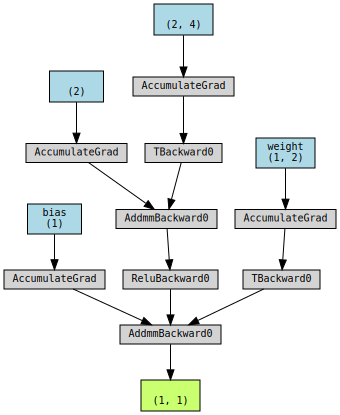

In [8]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(4, 2))
model.add_module('relu', nn.ReLU())
model.add_module('W1', nn.Linear(16, 1))

# 연산 그래프 시각화
make_dot(l3_output, params=dict(list(l1.named_parameters()) + list(l3.named_parameters())))

`detach()` 메소드를 활용하여 `grad_fn` 분리
  - 최적화 과정에서 미분 연산에 관여하고 싶지 않은 변수에 대하여, `grad_fn`을 분리
  - `grad_fn`이 분리된 변수는 최적화 과정에서 상수의 역할을 수행

In [9]:
l1_output = l1_output.detach()
l2_output = l2_output.detach()
l3_output = l3_output.detach()

print("l1_output:", l1_output)
print("l2_output:", l2_output)
print("l3_output:", l3_output)

l1_output: tensor([[-0.0508, -0.1563]])
l2_output: tensor([[0., 0.]])
l3_output: tensor([[0.4417]])


## 상태에 따라 행동 선택

State :
[-0.01467757  0.04324424  0.0271693  -0.02776104]
Action :
1
Next State :
[-0.01381268  0.23796624  0.02661408 -0.31174946]
Reward :
1.0
Done :
False


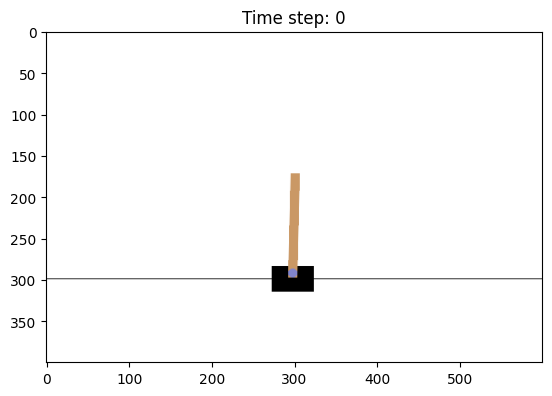

State :
tensor([-0.0138,  0.2380,  0.0266, -0.3117], device='cuda:0')
Action :
0
Next State :
[-0.00905336  0.04247544  0.02037909 -0.01079348]
Reward :
1.0
Done :
False


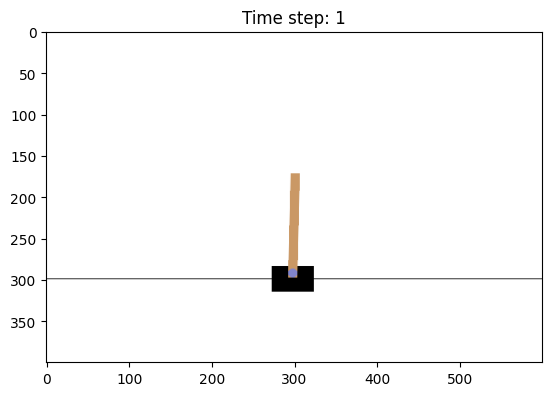

State :
tensor([-0.0091,  0.0425,  0.0204, -0.0108], device='cuda:0')
Action :
0
Next State :
[-0.00820385 -0.15293276  0.02016322  0.288249  ]
Reward :
1.0
Done :
False


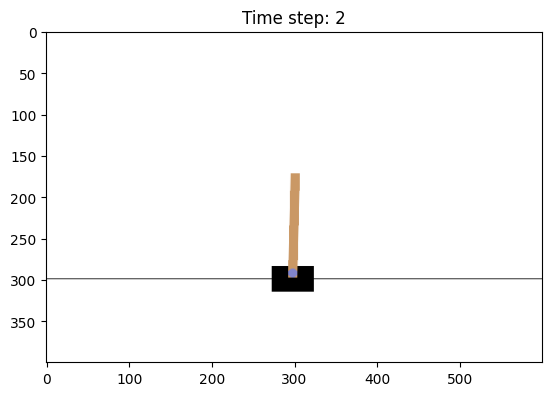

State :
tensor([-0.0082, -0.1529,  0.0202,  0.2882], device='cuda:0')
Action :
0
Next State :
[-0.01126251 -0.34833634  0.0259282   0.5872224 ]
Reward :
1.0
Done :
False


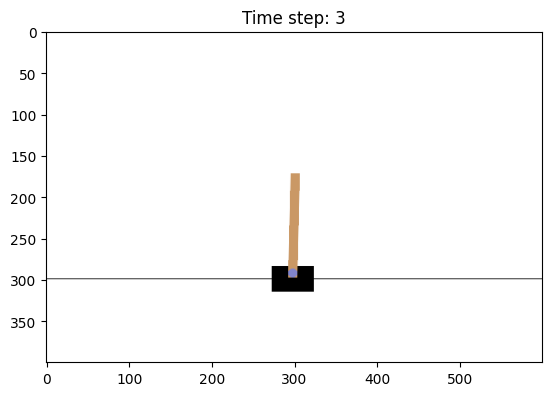

State :
tensor([-0.0113, -0.3483,  0.0259,  0.5872], device='cuda:0')
Action :
1
Next State :
[-0.01822923 -0.15358694  0.03767265  0.3028185 ]
Reward :
1.0
Done :
False


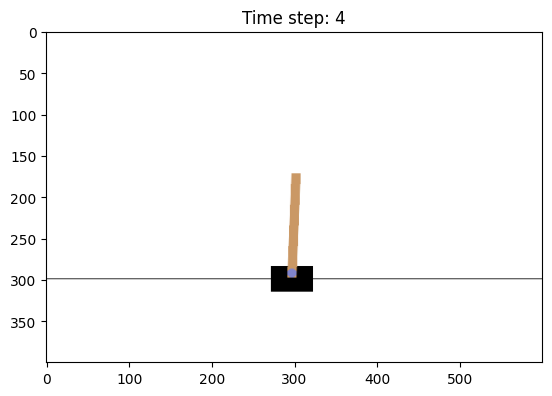

State :
tensor([-0.0182, -0.1536,  0.0377,  0.3028], device='cuda:0')
Action :
0
Next State :
[-0.02130097 -0.34922498  0.04372902  0.6071405 ]
Reward :
1.0
Done :
False


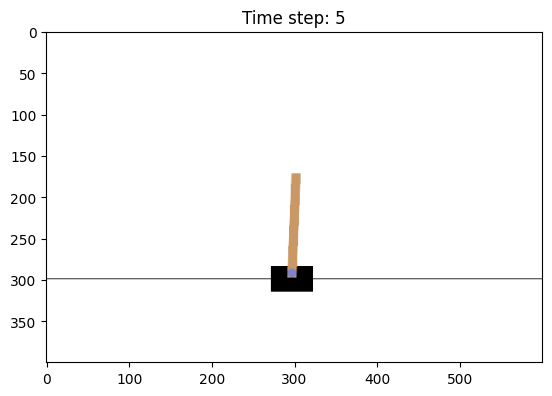

State :
tensor([-0.0213, -0.3492,  0.0437,  0.6071], device='cuda:0')
Action :
1
Next State :
[-0.02828547 -0.15474084  0.05587183  0.3285454 ]
Reward :
1.0
Done :
False


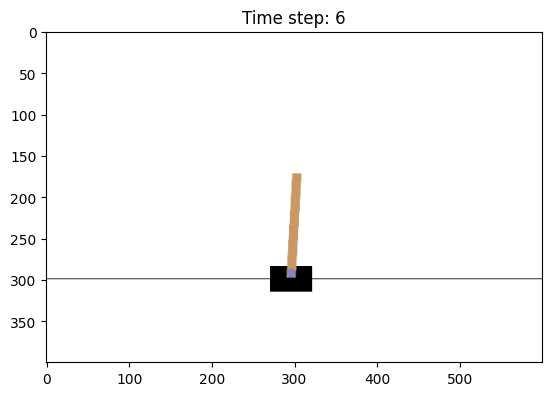

State :
tensor([-0.0283, -0.1547,  0.0559,  0.3285], device='cuda:0')
Action :
0
Next State :
[-0.03138029 -0.35061184  0.06244273  0.6383112 ]
Reward :
1.0
Done :
False


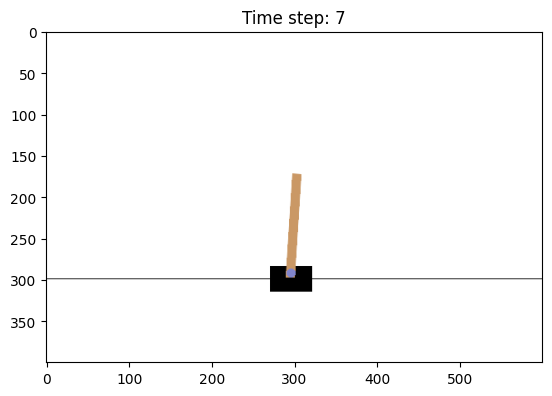

State :
tensor([-0.0314, -0.3506,  0.0624,  0.6383], device='cuda:0')
Action :
0
Next State :
[-0.03839253 -0.54654634  0.07520895  0.9499864 ]
Reward :
1.0
Done :
False


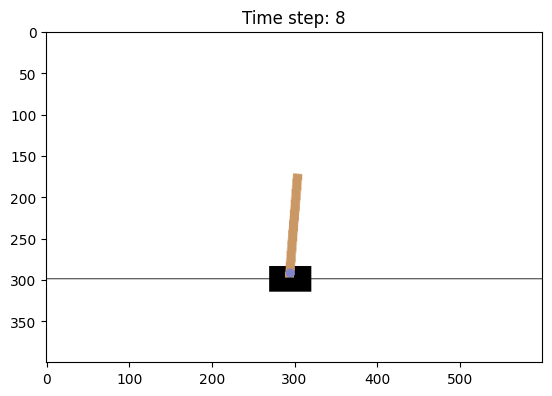

State :
tensor([-0.0384, -0.5465,  0.0752,  0.9500], device='cuda:0')
Action :
0
Next State :
[-0.04932345 -0.74259573  0.09420869  1.2653197 ]
Reward :
1.0
Done :
False


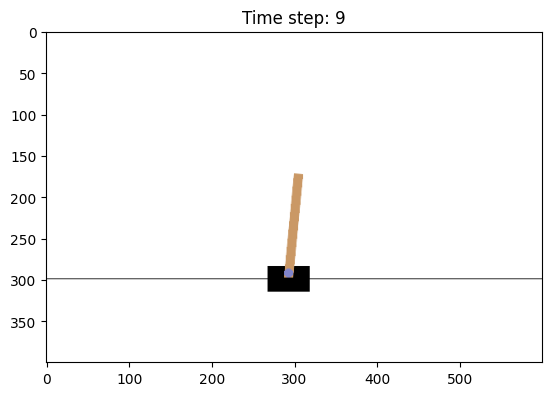

State :
tensor([-0.0493, -0.7426,  0.0942,  1.2653], device='cuda:0')
Action :
0
Next State :
[-0.06417537 -0.9387868   0.11951508  1.5859578 ]
Reward :
1.0
Done :
False


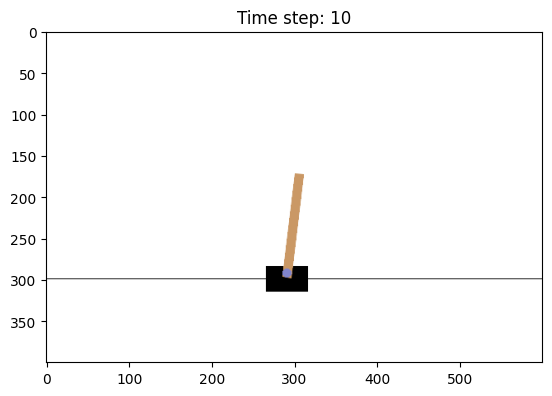

State :
tensor([-0.0642, -0.9388,  0.1195,  1.5860], device='cuda:0')
Action :
0
Next State :
[-0.0829511  -1.1351097   0.15123424  1.9133953 ]
Reward :
1.0
Done :
False


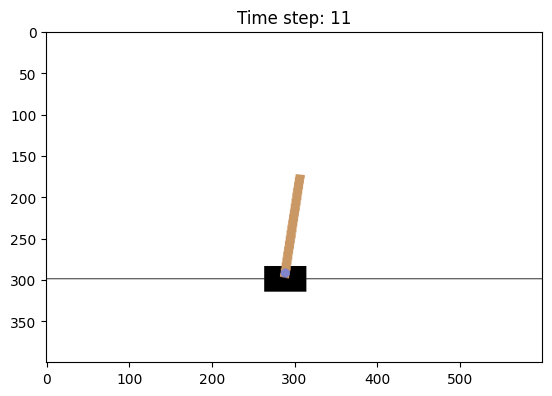

State :
tensor([-0.0830, -1.1351,  0.1512,  1.9134], device='cuda:0')
Action :
1
Next State :
[-0.10565329 -0.9419065   0.18950213  1.6711919 ]
Reward :
1.0
Done :
False


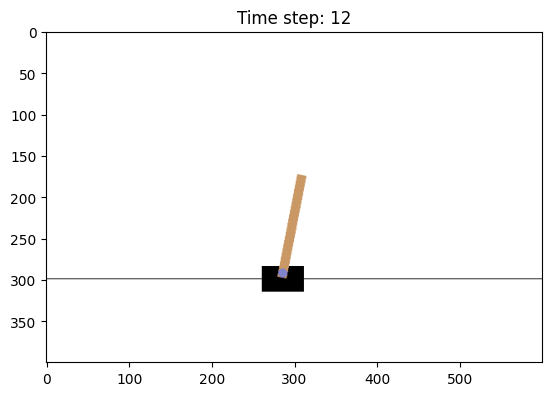

State :
tensor([-0.1057, -0.9419,  0.1895,  1.6712], device='cuda:0')
Action :
1
Next State :
[-0.12449142 -0.74942416  0.22292598  1.443018  ]
Reward :
1.0
Done :
True


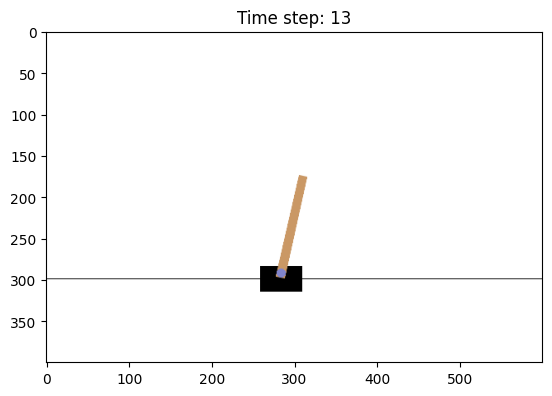

Total rewards : 14


In [11]:
done = False
obs = env.reset()

actions, states, rewards = [], [], []

total_rewards = 0
step = 0
# 에피소드가 끝날 때까지 반복
while not done:
    # 환경에서 무작위 행동 샘플링
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    print("State :")
    print(obs)
    print("Action :")
    print(action)
    print("Next State :")
    print(next_obs)
    print("Reward :")
    print(reward)
    print("Done :")
    print(done)

    ############   For render  ############# 
    plt.imshow(env.render()[0])
    plt.title(f'Time step: {step}')
    plt.show()
    ########################################

    # Trajectory 샘플 저장
    action = torch.tensor(action, dtype=torch.int).to(DEVICE)
    actions.append(action)
    states.append(obs)
    rewards.append(reward)
    total_rewards += reward

    # 다음 상태로 이동
    next_obs =  torch.tensor(next_obs, dtype=torch.float).to(DEVICE)
    obs = next_obs
    step += 1

print("Total rewards : %d"%total_rewards)

## 정책 네트워크를 활용한 행동 선택 (Remind)

`torch.distributions.Categorical`

: 범주형 분포를 나타내며, 각각의 카테고리(또는 클래스)에 대한 확률에 따라 샘플링 작업을 수행

In [12]:
import torch
from torch.distributions import Categorical

# 확률 벡터
probs = torch.tensor([0.2, 0.3, 0.5])  # 3개의 카테고리에 대한 확률

# Categorical 분포 객체 생성
dist = Categorical(probs)

# 확률에 따라 샘플링 수행
sample = dist.sample()

print("확률 : ", end='')
print(probs)
print("확률분포 : ", end='')
print(dist)
print("샘플 출력 : ", end='')
print(sample)

확률 : tensor([0.2000, 0.3000, 0.5000])
확률분포 : Categorical(probs: torch.Size([3]))
샘플 출력 : tensor(2)


In [13]:
# 무작위 샘플을 100번 실행
samples = []
for _ in range(100):
    samples.append(dist.sample().item())

# 각 카테고리별 빈도수 계산
frequencies = [0, 0, 0]
for sample in samples:
    frequencies[sample] += 1

print("샘플 발생 빈도수 : ", end='')
print(frequencies)

sampled_prob = []
for freq in frequencies:
    sampled_prob.append(freq / 100.0)

print("발생한 샘플의 확률 : ", end='')
print(sampled_prob)

샘플 발생 빈도수 : [11, 36, 53]
발생한 샘플의 확률 : [0.11, 0.36, 0.53]


### 범주형 분포를 활용한 행동 선택

1) 정책 네트워크를 활용하여 행동 확률 결정


2) 예측된 행동 확률에 따라 행동 선택

In [14]:
obs = torch.tensor(env.reset(), dtype=torch.float).to(DEVICE)

logits = actor_critic.policy_net(obs)
probs = F.softmax(logits, dim=-1)
dist = torch.distributions.Categorical(logits=logits)
action = dist.sample().item()

print("State : ", end='')
print(obs)
print("Logit : ", end='')
print(logits)
print("Probability : ", end='')
print(probs)
print("Distribution : ", end='')
print(dist)
print("Action : ", end='')
print(action)

State : tensor([ 0.0325, -0.0076, -0.0410, -0.0486], device='cuda:0')
Logit : tensor([-0.0869,  0.1108], device='cuda:0', grad_fn=<ViewBackward0>)
Probability : tensor([0.4507, 0.5493], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Distribution : Categorical(probs: torch.Size([2]), logits: torch.Size([2]))
Action : 1


행동 선택 과정을 함수화(`action_decide`)
 - 입력변수 : 정책 네트워크, 관측(상태) 데이터(`obs`)
 - 출력 값 : 샘플링된 행동(`action`)
 - 역할 : 입력 받은 관측 데이터를 바탕으로 네트워크를 활용해 가치를 판단하고, 확률 분포에 따라 행동 선택

In [15]:
def action_decide(network, obs):
    obs = torch.tensor([obs], dtype=torch.float).to(DEVICE)

    ################################## 코드 작성 ###################################

    # 상태에 따라 정책의 logit 예측
    logit, _ = network.forward(obs)
    if logit.dim() == 1:
        logit = logit.unsqueeze(0)
    # logit의 값에 따라 행동 선택 확률 계산
    prob = F.softmax(logit, dim=-1)
    # 확률 분포 구성
    m = Categorical(prob)
    # 확률에 따라 행동 선택
    action = m.sample().item()

    ################################################################################

    return action

## 3. Episode 샘플을 활용한 반환 값 계산

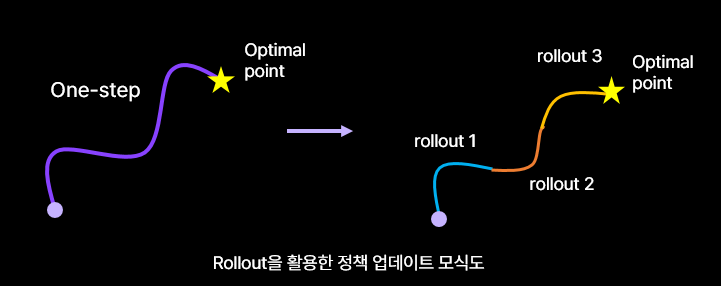

에피소드 내 데이터 일부를 활용한 반환 값 계산
 - 기존 REINFORCE 알고리즘은 에피소드 내 모든 데이터를 활용하여 반환 값 계산
 - A2C 알고리즘은 에피소드 내 N-step 데이터를 활용하기 떄문에 마지막 상태 이후의 가치에 대해 예측이 필요함

In [16]:
max_time_step = 5
gamma = 0.99

time_step = 1
done = False
obs = env.reset()
total_reward = 0

current_state = []
current_action = []
next_states = []
rewards = []
returns = []

while not done:

    ################################## 코드 작성 ###################################

    # action_decide함수를 활용한 행동 결정 및 환경과 교류
    action = action_decide(actor_critic, obs)
    next_obs, reward, done, info = env.step(action)
    total_reward += reward

    # 각 상태, 행동, 보상 배열에 rollout 샘플 저장
    current_state.append(obs)
    current_action.append(action)
    next_states.append(next_obs)
    rewards.append(reward)

    ################################################################################

    if time_step % max_time_step == 0 or done:
        states = torch.tensor(current_state, dtype=torch.float).to(DEVICE)
        actions = torch.tensor(current_action, dtype=torch.int64).to(DEVICE)
        next_states = torch.tensor(next_states, dtype=torch.float).to(DEVICE)

        ################################## 코드 작성 ###################################

        # 현재 Trajectory의 마지막 상태에 대한 값 예측, 에피소드가 끝났다면 다음 상태의 반환 값을 전파하지 않음
        _, v_next = actor_critic(next_states[-1])
        # 에피소드가 끝났다면 다음 상태의 반환 값을 전파하지 않음
        R = v_next * (1 - int(done))

        # rewards의 역순부터 반환 값 계산
        batch_return = []

        for reward in rewards[::-1]:
            R = reward + gamma * R
            batch_return.append(R)
        batch_return.reverse()

        returns.append(batch_return)

        # Rollout이 끝났을 경우, 샘플들을 초기화
        current_state = []
        current_action = []
        next_states = []
        rewards = []

        ################################################################################

    time_step += 1
    obs = next_obs

/tmp/ipykernel_68/3365748731.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  obs = torch.tensor([obs], dtype=torch.float).to(DEVICE)


Total time step : 15


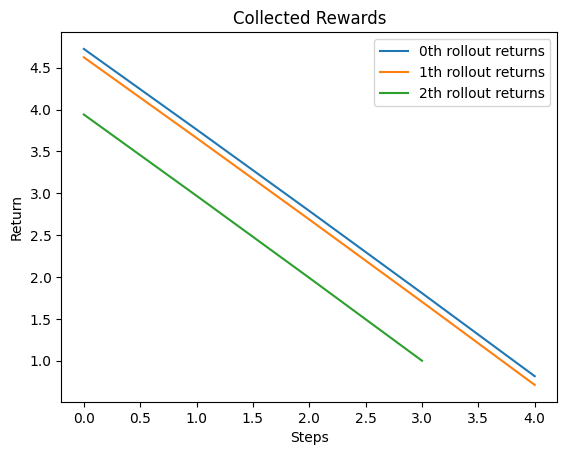

In [17]:
print("Total time step : %d"%time_step)
for i, rollout_return in enumerate(returns):
  plt.title("Collected Rewards")
  plt.xlabel("Steps")
  plt.ylabel("Return")
  plt.plot(torch.Tensor(rollout_return).cpu().detach().numpy(), label=f'{i}th rollout returns')
  plt.legend()
plt.show()
plt.close()

반환 값 계산 과정 함수화(`get_returns`)
 - 입력변수 : 정책 네트워크, Rollout된 다음 상태의 관측 데이터(`next_states`), Rollout된 보상값(`rewards`), Terminal 여부(`done`)
 - 출력 값 : Rollout 데이터들의 반환 값
 - 역할 : Rollout된 데이터들을 입력받아 각각의 반환 값을 예측. 에피소드가 끝나기 전에 반환 값을 예측해야함으로, 마지막 다음 상태들 활용하여 이후의 가치를 예측하여 반환 값 예측에 활용

In [18]:
# 정책의 반환 값 계산
def get_returns(net, next_states, rewards, done, gamma=0.99):

    ################################## 코드 작성 ###################################

    # 현재 Trajectory의 마지막 상태에 대한 값 예측, 에피소드가 끝났다면 다음 상태의 반환 값을 전파하지 않음
    _, v_next = net.forward(next_states[-1])

    R = v_next * (1 - int(done))

    # rewards의 역순부터 반환 값 계산
    batch_return = []

    for reward in rewards[::-1]:
        R = reward + gamma * R
        batch_return.append(R)
    batch_return.reverse()

    ################################################################################

    return batch_return

## 목적 함수를 활용한 정책 업데이트



A2C의 목적 함수 $J(\theta)$에 대한 정책 경사 :

$\hat{\nabla}_{\theta} J(\theta) = \nabla_{\theta} \log \pi_{\theta}(s_t, a_t) A_t$

, where $𝐴_𝑡^{(𝑛)} (𝑠,𝑎) = \sum\limits_{l=0}^{n-1} \gamma^l 𝑟(𝑠_{t+l}, a_{t+l}) + \gamma^{n}V(𝑠_{t+n}) - V(𝑠_t)$


- Advantage 값에 따라 행동의 결정 확률 최대화
- 에이전트의 행동이 좋은 결과(높은 Advantage)를 가져오면 그 행동을 더 자주 취하도록 정책을 조정

1) Advantage 값 계산


In [19]:
_, state_value = actor_critic.forward(states)
last_rollout_returns = torch.Tensor(returns[-1]).unsqueeze(1).to(DEVICE)

################################## 코드 작성 ###################################

# 예측된 상태 예측값을 활용해 Advantage 값 계산
advantage = last_rollout_returns - state_value

################################################################################

print(advantage)

tensor([[4.2320],
        [3.1938],
        [2.1573],
        [1.2474]], device='cuda:0', grad_fn=<SubBackward0>)


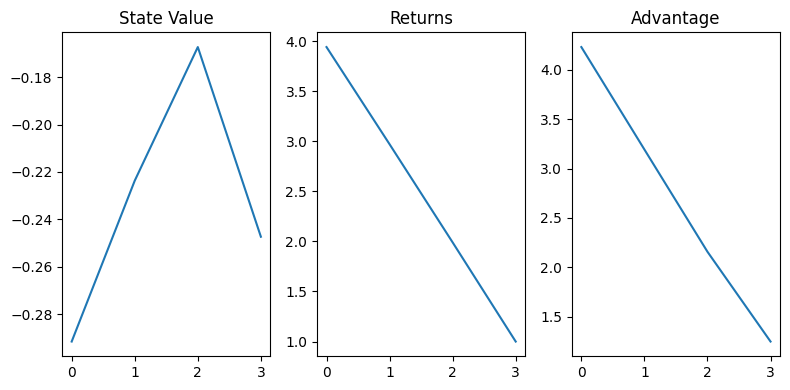

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

state_value = state_value.cpu().detach()
last_rollout_returns = last_rollout_returns.cpu().detach()
advantage = advantage.cpu().detach()

# 각 subplot에 데이터 그리기
axs[0].plot(np.array(state_value))
axs[0].set_title('State Value')

axs[1].plot(np.array(last_rollout_returns))
axs[1].set_title('Returns')

axs[2].plot(np.array(advantage))
axs[2].set_title('Advantage')


# 그래프 표시
plt.tight_layout()
plt.show()

2) Advantage 값을 활용한 목적함수 최적화

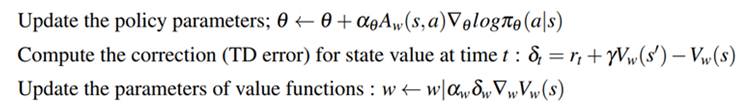

단, 이 때 td error($\delta_{t})$ 대신 $𝐴_𝑡^{(𝑛)} (𝑠,𝑎) = \sum\limits_{l=0}^{n-1} \gamma^l 𝑟(𝑠_{t+l}, a_{t+l}) + \gamma^{n}V(𝑠_{t+n}) - V(𝑠_t)$ 사용

`gather`함수는 log_prob들 중 선택된 action에 대한 log_prob만 선택


In [21]:
ex_log_prob = torch.tensor(
    [[-1.2, -0.8, -1.0],
     [-1.1, -0.9, -0.7],
     [-1.4, -0.6, -1.2]])
ex_actions = torch.tensor([0, 2, 1]).unsqueeze(1)

gather_log_prob = ex_log_prob.gather(1, ex_actions)
print(gather_log_prob)

tensor([[-1.2000],
        [-0.7000],
        [-0.6000]])


In [22]:
################################## 코드 작성 ###################################

# 네트워크를 활용한 상태 logit 예측
logits, state_value = actor_critic.forward(states)
logits = logits.view(-1, actor_critic.act_dim)

# logit을 활용하여 log probability 계산
log_prob = F.log_softmax(logits, dim=1)
actions = actions.view(-1, 1)

# 현재 action에 대한 log_prob 획득
log_prob_act = log_prob.gather(1, actions)

################################################################################


In [23]:
advantage = torch.Tensor(advantage).unsqueeze(1).to(DEVICE)

################################## 코드 작성 ###################################

# Actor가 Advantage 값을 최대화하도록 학습, 오차 함수 명 : 'loss_policy'
loss_policy = - (advantage.detach() * log_prob_act).mean()

# Critic이 Advantage 값을 예측하도록 학습, 오차 함수 명 : 'loss_critic'
loss_critic = 0.5 * advantage.pow(2.).mean()

################################################################################

loss = loss_policy + loss_critic

print(f'loss_policy : {loss_policy}')
print(f'loss_critic : {loss_critic}')
print(f'loss : {loss}')

loss_policy : 2.117888927459717
loss_critic : 4.290016174316406
loss : 6.407905101776123


네트워크 업데이트 함수화(`a2c_update`)
 - 입력변수 : 정책 네트워크, Rollout된 데이터들
 - 출력 값 : 계산된 loss 값
 - 역할 : Rollout된 데이터들을 return 및 advantage 값을 계산하고, 각각의 목적함수에 맞는 오차함수 계산

In [24]:
def a2c_update(net, done, current_state, current_action, next_states, rewards):

    ################################## 코드 작성 ###################################

    # Trajectory 단위의 데이터 구성
    states = torch.tensor(current_state, dtype=torch.float).to(DEVICE)
    actions = torch.tensor(current_action, dtype=torch.int64).to(DEVICE)
    next_states = torch.tensor(next_states, dtype=torch.float).to(DEVICE)

    # 반환 값 계산
    returns = get_returns(net, next_states, rewards, done)

    # 현재 상태에 따라 행동 선택
    logits, state_value = net.forward(states)
    logits = logits.view(-1, net.act_dim)
    log_prob = F.log_softmax(logits, dim=1)
    actions = actions.view(-1, 1)
    log_prob_act = log_prob.gather(1, actions)

    returns = torch.Tensor(returns).unsqueeze(1).to(DEVICE)

    # Advantage 함수 계산
    # r_t + V(s_(t+1)) - V(s_t)
    advantage = returns - state_value

    # Actor 행동의 Advantage 최대화
    loss_policy = - (advantage.detach() * log_prob_act).mean()

    # Critic이 advantage함수를 예측하도록 학습
    loss_critic = 0.5 * advantage.pow(2.).mean()

    ################################################################################

    loss = loss_policy + loss_critic

    return loss

## 전체 학습 코드

In [25]:
env_name = 'CartPole-v1'

env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
n_action = env.action_space.n

lr = 1e-3
gamma = 0.99
max_epi_num = 1000

actor_critic = Actor_Critic(obs_dim, n_action).to(DEVICE)
optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

/home/elicer/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/elicer/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [26]:
env_name = 'CartPole-v1'

env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
n_action = env.action_space.n

lr = 1e-3
gamma = 0.99

actor_critic = Actor_Critic(obs_dim, n_action).to(DEVICE)
optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

/home/elicer/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/elicer/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [27]:
# 최대 Episode 횟수 결정
max_epi_num = 1000
# Episode 내 최대 timestep 횟수 결정
max_time_step = 10
time_step = 1

# 에피소드 동안 획득한 reward 값 비교
a2c_results_reward = []
advantages = []
actor_losses = []
critic_losses = []
total_losses = []

for i in range(max_epi_num):

    done = False
    obs = env.reset()
    total_reward = 0

    current_state = []
    current_action = []
    next_states = []
    rewards = []


    while not done:

        ################################## 코드 작성 ###################################

        # action_decide함수를 활용한 행동 결정 및 환경과 교류
        action = action_decide(actor_critic, obs)
        next_obs, reward, done, info = env.step(action)
        total_reward += reward

        # 각 상태, 행동, 보상 배열에 rollout 샘플 저장
        current_state.append(obs)
        current_action.append(action)
        next_states.append(next_obs)
        rewards.append(reward)

        ################################################################################

        if time_step % max_time_step == 0 or done:
            # Trajectory 단위의 데이터 구성
            states = torch.tensor(current_state, dtype=torch.float).to(DEVICE)
            actions = torch.tensor(current_action, dtype=torch.int64).to(DEVICE)
            next_states = torch.tensor(next_states, dtype=torch.float).to(DEVICE)

            ################################## 코드 작성 ###################################

            # 반환 값 계산
            _, v_next = actor_critic.forward(next_states[-1])

            # 현재 Trajectory의 마지막 상태에 대한 값 예측, 에피소드가 끝났다면 다음 상태의 반환 값을 전파하지 않음
            R = v_next * (1 - int(done))

            returns = []

            # rewards의 역순부터 반환 값 계산
            for reward in rewards[::-1]:
                R = reward + gamma * R
                returns.append(R)
            returns.reverse()
            ################################################################################

            returns = torch.Tensor(returns).unsqueeze(1).to(DEVICE)

            ################################## 코드 작성 ###################################

            # 네트워크를 활용한 상태 logit 예측
            logits, state_value = actor_critic.forward(states)
            logits = logits.view(-1, actor_critic.act_dim)
            # logit을 활용하여 log probability 계산
            log_prob = F.log_softmax(logits, dim=1)
            actions = actions.view(-1, 1)
            log_prob_act = log_prob.gather(1, actions)
            ################################################################################

            ################################## 코드 작성 ###################################

            # Advantage 함수 계산
            # r_t + V(s_(t+1)) - V(s_t)
            advantage = returns - state_value

            # Actor 행동의 Advantage 최대화
            loss_policy = - (advantage.detach() * log_prob_act).mean()

            # Critic이 advantage함수를 예측하도록 학습
            loss_critic = 0.5 * advantage.pow(2.).mean()

            ################################################################################

            loss = loss_policy + loss_critic

            actor_losses.append(loss_policy.item())
            critic_losses.append(loss_critic.item())
            total_losses.append(loss.item())
            advantages += (list(advantage.detach().cpu().numpy().squeeze(-1)))

            # 오차 함수를 활용한 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ################################################################################

            current_state = []
            current_action = []
            next_states = []
            rewards = []

        time_step += 1
        obs = next_obs

    if i % 100 == 0 and i != 0:
        print(f'epsiode: {i}, score: {np.mean(a2c_results_reward[-10:])}')
    a2c_results_reward.append(total_reward)

env.close()

epsiode: 100, score: 15.3
epsiode: 200, score: 50.0
epsiode: 300, score: 138.2
epsiode: 400, score: 177.1
epsiode: 500, score: 246.3
epsiode: 600, score: 124.5
epsiode: 700, score: 146.8
epsiode: 800, score: 116.5
epsiode: 900, score: 184.5


## 구현 결과 분석

### 네트워크 loss 비교

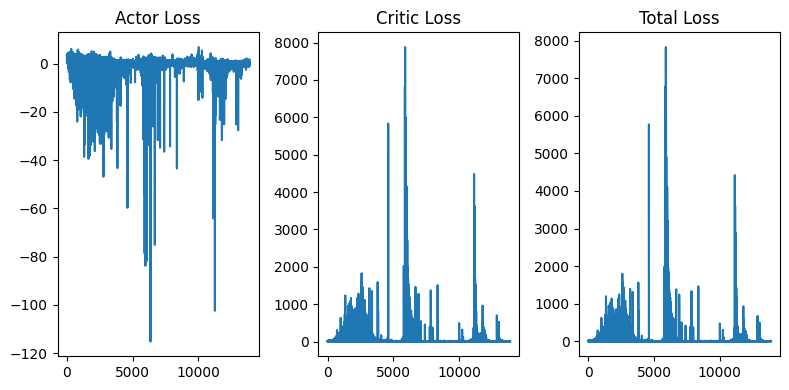

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# 각 subplot에 데이터 그리기
axs[0].plot(np.array(actor_losses))
axs[0].set_title('Actor Loss')

axs[1].plot(np.array(critic_losses))
axs[1].set_title('Critic Loss')

axs[2].plot(np.array(total_losses))
axs[2].set_title('Total Loss')


# 그래프 표시
plt.tight_layout()
plt.show()

### 마지막 에피소드의 Advantage 값 관측

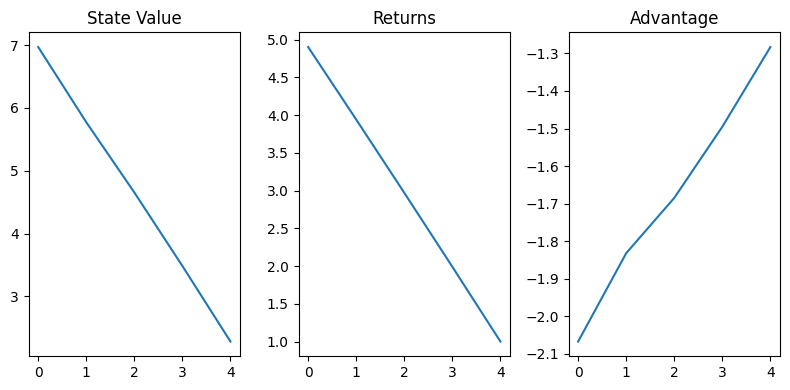

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

state_value = state_value.cpu().detach()
returns = returns.cpu().detach()
advantage = advantage.cpu().detach()

# 각 subplot에 데이터 그리기
axs[0].plot(np.array(state_value))
axs[0].set_title('State Value')

axs[1].plot(np.array(returns))
axs[1].set_title('Returns')

axs[2].plot(np.array(advantage))
axs[2].set_title('Advantage')


# 그래프 표시
plt.tight_layout()
plt.show()

### Advantage 값의 향상률 관측

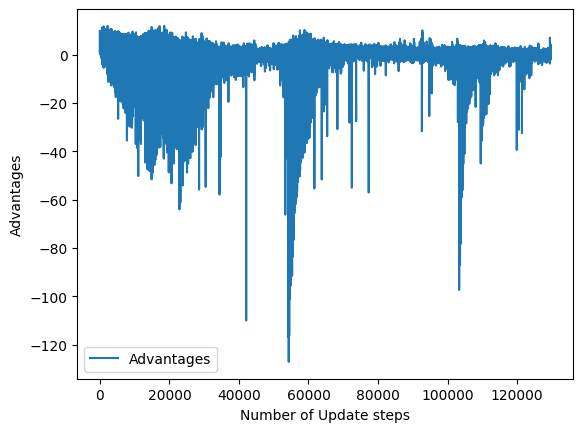

In [30]:
plt.xlabel("Number of Update steps")
plt.ylabel("Advantages")
plt.plot(advantages, label='Advantages')
plt.legend()
plt.show()
plt.close()

### A2C 알고리즘의 성능 향상

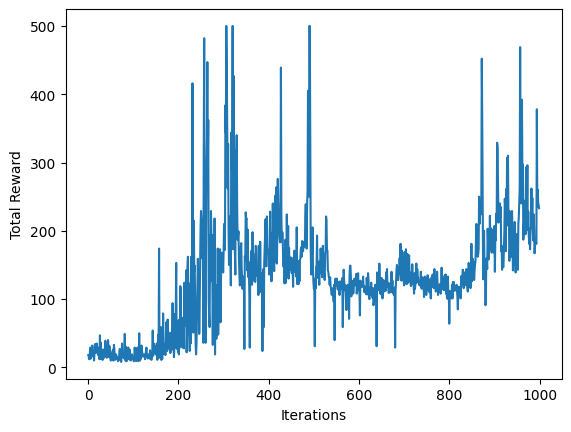

In [31]:
plt.xlabel("Iterations")
plt.ylabel("Total Reward")
plt.plot(np.array(a2c_results_reward))
plt.savefig(f'./A2C performance.png')
np.save(f'./A2C_performance.npy', np.array(a2c_results_reward))

### REINFORCE 알고리즘과 비교

기존 A2C 알고리즘과의 차이점


1.   Episode의 전체 step을 활용해서 return 계산

2.   Advantage 값이 아닌 Return 값을 활용하여 업데이트



In [32]:
env_name = 'CartPole-v1'

env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
n_action = env.action_space.n

lr = 1e-3
gamma = 0.99
hidden_layers = [128, 128]

actor_critic = Actor_Critic(obs_dim, n_action).to(DEVICE)
optimizer = optim.Adam(actor_critic.parameters(), lr=lr)

In [33]:
def reinf_update(net, done, current_state, current_action, next_states, rewards):

    # Trajectory 단위의 데이터 구성
    states = torch.tensor(current_state, dtype=torch.float).to(DEVICE)
    actions = torch.tensor(current_action, dtype=torch.int64).to(DEVICE)
    next_states = torch.tensor(next_states, dtype=torch.float).to(DEVICE)

    # 반환 값 계산
    returns = get_returns(net, next_states, rewards, done)

    # 현재 상태에 따라 행동 선택
    logits, state_value = net.forward(states)
    logits = logits.view(-1, net.act_dim)
    log_prob = F.log_softmax(logits, dim=1)
    actions = actions.view(-1, 1)
    log_prob_act = log_prob.gather(1, actions)

    returns = torch.Tensor(returns).unsqueeze(1).to(DEVICE)

    ################################## 코드 작성 ###################################

    # Actor 행동의 Returns 최대화
    loss_policy = - (returns.detach() * log_prob_act).mean()

    # Critic이 return함수를 예측하도록 학습
    loss_critic = 0.5 * returns.pow(2.).mean()

    ################################################################################

    loss = loss_policy + loss_critic

    return loss

In [34]:
# 최대 Episode 횟수 결정
max_epi_num = 1000

# 에피소드 동안 획득한 reward 값 비교
reinf_results_reward = []
losses = []

for i in range(max_epi_num):

    done = False
    obs = env.reset()
    total_reward = 0

    current_state = []
    current_action = []
    next_states = []
    rewards = []


    while not done:
        # 행동 결정을 통해 환경과 교류
        action = action_decide(actor_critic, obs)
        next_obs, reward, done, info = env.step(action)
        total_reward += reward

        current_state.append(obs)
        current_action.append(action)
        next_states.append(next_obs)
        rewards.append(reward)

        if done:

            # Trajectory 단위의 데이터 구성
            states = torch.tensor(current_state, dtype=torch.float).to(DEVICE)
            actions = torch.tensor(current_action, dtype=torch.int64).to(DEVICE)
            next_states = torch.tensor(next_states, dtype=torch.float).to(DEVICE)

            # 반환 값 계산
            _, v_next = actor_critic.forward(next_states[-1])

            R = v_next * (1 - int(done))

            returns = []

            # rewards의 역순부터 반환 값 계산
            for reward in rewards[::-1]:
                R = reward + gamma * R
                returns.append(R)
            returns.reverse()

            # 현재 상태에 따라 행동 선택
            logits, state_value = actor_critic.forward(states)
            logits = logits.view(-1, actor_critic.act_dim)
            log_prob = F.log_softmax(logits, dim=1)
            actions = actions.view(-1, 1)
            log_prob_act = log_prob.gather(1, actions)

            returns = torch.Tensor(returns).unsqueeze(1).to(DEVICE)

            ################################## 코드 작성 ###################################

            # Actor 행동의 Returns 최대화
            loss_policy = - (returns.detach() * log_prob_act).mean()

            # Critic이 return함수를 예측하도록 학습
            loss_critic = 0.5 * returns.pow(2.).mean()

            ################################################################################

            loss = loss_policy + loss_critic

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current_state = []
            current_action = []
            next_states = []
            rewards = []

        obs = next_obs

    if i % 100 == 0 and i != 0:
        print(f'epsiode: {i}, score: {np.mean(reinf_results_reward[-10:])}')
    reinf_results_reward.append(total_reward)

env.close()

epsiode: 100, score: 38.3
epsiode: 200, score: 42.8
epsiode: 300, score: 89.5
epsiode: 400, score: 73.0
epsiode: 500, score: 83.8
epsiode: 600, score: 229.6
epsiode: 700, score: 271.6
epsiode: 800, score: 167.9
epsiode: 900, score: 131.5


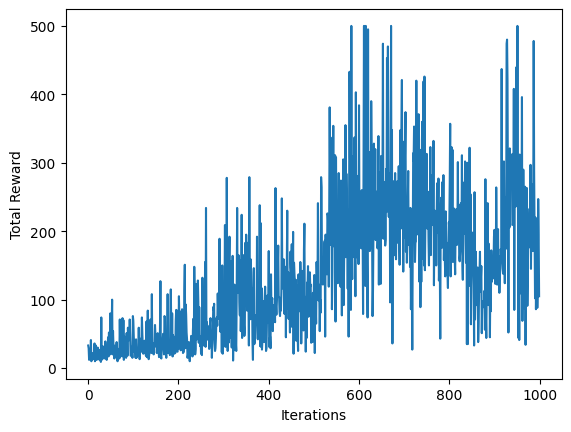

In [35]:
plt.xlabel("Iterations")
plt.ylabel("Total Reward")
plt.plot(np.array(reinf_results_reward))
plt.savefig(f'./REINFORCE performance.png')
np.save(f'./REINFORCE_performance.npy', np.array(reinf_results_reward))

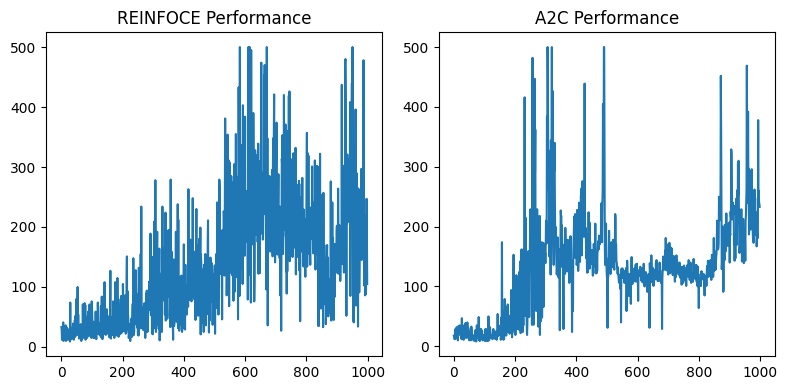

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# 각 subplot에 데이터 그리기
axs[0].plot(np.array(reinf_results_reward))
axs[0].set_title('REINFOCE Performance')

axs[1].plot(np.array(a2c_results_reward))
axs[1].set_title('A2C Performance')

# 그래프 표시
plt.tight_layout()
plt.show()